In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import re

os.chdir('C:\\Users\\Admin\\Desktop\\phd\\multivariate_hawkes\\src')

from lob_event_type_indicator import LOBEventTypeIndicator
from lob_event_type import LOBEventType
num_levels_in_a_side = 10
num_levels_for_which_save_events = 4

LOBSTER_LOB_DF_PATH = '..\\data\\amazon_lob_10_levels_lobster\\AMZN_2012-06-21_34200000_57600000_orderbook_10.csv'
LOBSTER_MSG_DF_PATH = '..\\data\\amazon_lob_10_levels_lobster\\AMZN_2012-06-21_34200000_57600000_message_10.csv'

In [35]:
def get_lobster_lob_df(path: str) -> pd.DataFrame:    
    col_name_prefixes = ['AskPrice', 'AskSize', 'BidPrice', 'BidSize']

    col_names = list()
    for i in range(10):
        col_names.extend(
            [p + str(i+1) for p in col_name_prefixes]
        )

    lob_df = pd.read_csv(path, header=None, names = col_names)
    return lob_df

def get_lobster_msg_df(path: str) -> pd.DataFrame:
    col_names = ['Time', 'Type', 'Id', 'Size', 'Price', 'Direction']
    msg_df = pd.read_csv(
        path,
        header=None,
        names = col_names
    )

    type_int_to_name_map = {
        1: 'NewLimit', 2: 'Cancellation', 3: 'CancellationTotal', 4: 'ExecutionVisible', 5: 'ExecutionHidden'
    }
    msg_df['Type'] = msg_df['Type'].apply(lambda x: type_int_to_name_map[x])
    msg_df = msg_df[['Time', 'Type', 'Size', 'Price', 'Direction']]
    msg_df['Direction'] = msg_df['Direction'].apply(lambda x: 'BID' if x == 1 else 'ASK')

    return msg_df

def update_lobster_msg_df_with_incremental_time(msg_df: pd.DataFrame) -> None:
    msg_df['Time'] = msg_df.index


def get_changed_columns_wrt_prev_row(df: pd.DataFrame) -> pd.Series:
    df_shifted = df.shift(1)
    changed = df != df_shifted
    return changed.apply(lambda row: df.columns[row].to_list(), axis=1)

def update_lobster_msg_df_with_changer(
    msg_df: pd.DataFrame, lob_df_changed_columns_serie: pd.Series
) -> None:
    msg_df['Changed'] = lob_df_changed_columns_serie
    msg_df['Changer'] = msg_df[['Changed', 'Type']].apply(
        lambda x: False if x['Type'] == 'ExecutionHidden'
        else('AskPrice1' in x['Changed'] or 'BidPrice1' in x['Changed']),
        axis=1
    )
    msg_df['ChangerSize'] = msg_df[['Changed', 'Type']].apply(
        lambda x: False if x['Type'] == 'ExecutionHidden'
        else('AskSize1' in x['Changed'] or 'BidSize1' in x['Changed']),
        axis=1
    )


def get_lobster_msg_df_with_events(msg_df: pd.DataFrame) -> pd.DataFrame:
    msg_df_for_events = msg_df[msg_df['Type'] != 'ExecutionHidden'].copy()

    lobster_name_my_name_map = {
        'NewLimit': 'LIMIT',
        'ExecutionVisible': 'MARKET',
        'Cancellation': 'CANCELLED',
        'CancellationTotal': 'CANCELLED'
    }

    msg_df_for_events['Type'] = msg_df_for_events['Type'].apply(lambda x: lobster_name_my_name_map[x])
    msg_df_for_events['EventName'] = (
        msg_df_for_events['Direction'] + '_' +
        msg_df_for_events['Type'] + '_ORDER_' +
        msg_df_for_events['Changer'].apply(lambda x: 'CHANGER' if x else 'NOT_CHANGER')
    )

    return msg_df_for_events

def get_lobster_msg_df_with_events_cancelled_changer_as_market(
    msg_df_for_events: pd.DataFrame
) -> pd.DataFrame:
    msg_df_for_events['EventName'] = msg_df_for_events['EventName'].apply(
        lambda x: 'BID_MARKET_ORDER_CHANGER' if x == 'BID_CANCELLED_ORDER_CHANGER' else x
    )
    msg_df_for_events['EventName'] = msg_df_for_events['EventName'].apply(
        lambda x: 'ASK_MARKET_ORDER_CHANGER' if x == 'ASK_CANCELLED_ORDER_CHANGER' else x
    )

    msg_df_for_events['EventName'] = msg_df_for_events[['EventName', 'ChangerSize']].apply(
        lambda x: 'BID_MARKET_ORDER_NOT_CHANGER'
        if (x['EventName'] == 'BID_CANCELLED_ORDER_NOT_CHANGER' and x['ChangerSize'] == True)
        else x['EventName'], axis=1
    )
    msg_df_for_events['EventName'] = msg_df_for_events[['EventName', 'ChangerSize']].apply(
        lambda x: 'ASK_MARKET_ORDER_NOT_CHANGER'
        if (x['EventName'] == 'ASK_CANCELLED_ORDER_NOT_CHANGER' and x['ChangerSize'] == True)
        else x['EventName'], axis=1
    )
    return msg_df_for_events

def update_lobster_lob_df_for_event_indicator(lob_df: pd.DataFrame, time_series: pd.Series) -> None:
    lob_df['Timestamp'] = time_series
    lob_df.drop(columns='Changed', inplace=True)
    lob_df.drop_duplicates(subset='Timestamp', keep = 'last', inplace=True)
    lob_df['Timestamp'] = (time_series).astype(np.uint64)

def extract_number(string: str) -> int:
    match = re.search(r'(\d+)$', string)
    return int(match.group(1)) if match else None

def get_lobster_msg_df_with_events_until_max_level(
    msg_df_with_events: pd.DataFrame, max_level: int
) -> pd.DataFrame:
    rows_to_keep = msg_df_with_events['Changed'].apply(
        lambda x: min([extract_number(name_changed_column) for name_changed_column in x]) <= max_level
    )

    return msg_df_with_events[rows_to_keep].copy()

In [36]:
lob_df = get_lobster_lob_df(LOBSTER_LOB_DF_PATH)
lob_df['Changed'] = get_changed_columns_wrt_prev_row(lob_df)

msg_df = get_lobster_msg_df(LOBSTER_MSG_DF_PATH)

# In this way each row of lob_df is a different timestamp and I can compare results of my algoritm with the ones of the msg_df

update_lobster_msg_df_with_changer(msg_df, lob_df['Changed'])
update_lobster_msg_df_with_incremental_time(msg_df) 
msg_df_for_events = get_lobster_msg_df_with_events(msg_df)
msg_df_for_events = get_lobster_msg_df_with_events_cancelled_changer_as_market(msg_df_for_events)

update_lobster_lob_df_for_event_indicator(lob_df, msg_df_for_events['Time'])

In [37]:
reduced_lob_df = lob_df[lob_df.index.isin(range(0, 1000))]
lob_type_event_indicator = LOBEventTypeIndicator(
    reduced_lob_df, num_levels_in_a_side, num_levels_for_which_save_events
)
event_type_times_map = lob_type_event_indicator.get_lob_event_type_times_map()
event_type_times_map

{<LOBEventType.ASK_LIMIT_ORDER_NOT_CHANGER: 8>: array([  2,   4,   6,   8,  10,  12,  13,  14,  15,  16,  17,  18,  19,
         20,  21,  22,  23,  24,  25,  26,  27,  39,  55, 134, 136, 138,
        140, 142, 144, 146, 152, 158, 160, 162, 164, 166, 168, 170, 172,
        174, 176, 178, 180, 182, 184, 186, 198, 201, 203, 205, 206, 221,
        239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263,
        268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292,
        294, 296, 298, 300, 307, 319, 357, 359, 361, 363, 365, 367, 369,
        371, 373, 375, 377, 379, 381, 383, 389, 398, 409, 412, 418, 481,
        490, 529, 538, 716, 735, 738, 760, 764, 768, 771, 777, 780, 787,
        800, 805, 806, 816, 821, 826, 831, 833, 835, 869, 871, 873, 875,
        877, 879, 881, 883, 885, 887, 889, 891, 893, 895, 896, 897, 903,
        908, 913, 915, 917, 920, 923, 926, 928, 934, 936]),
 <LOBEventType.BID_LIMIT_ORDER_NOT_CHANGER: 7>: array([  3,   5,   7,  47,  85,  87,  91, 

In [38]:
msg_df_for_events['Time'] = (msg_df_for_events['Time']).astype(np.uint64)
msg_df_for_events

,Time,Type,Size,Price,Direction,Changed,Changer,ChangerSize,EventName
1,1,LIMIT,21,2238100,BID,"[BidPrice1, BidSize1, BidPrice2, BidSize2, Bid...",True,True,BID_LIMIT_ORDER_CHANGER
2,2,LIMIT,20,2239600,ASK,"[AskPrice2, AskSize2, AskPrice3, AskSize3, Ask...",False,False,ASK_LIMIT_ORDER_NOT_CHANGER
3,3,LIMIT,100,2237500,BID,"[BidPrice2, BidPrice3, BidSize3, BidPrice4, Bi...",False,False,BID_LIMIT_ORDER_NOT_CHANGER
4,4,LIMIT,13,2240000,ASK,[AskSize4],False,False,ASK_LIMIT_ORDER_NOT_CHANGER
5,5,LIMIT,2,2236500,BID,"[BidPrice3, BidSize3, BidPrice4, BidSize4, Bid...",False,False,BID_LIMIT_ORDER_NOT_CHANGER
...,...,...,...,...,...,...,...,...,...
269743,269743,CANCELLED,100,2207600,ASK,[AskSize9],False,False,ASK_CANCELLED_ORDER_NOT_CHANGER
269744,269744,CANCELLED,100,2206200,ASK,"[AskPrice1, AskPrice2, AskSize2, AskPrice3, As...",True,False,ASK_MARKET_ORDER_CHANGER
269745,269745,CANCELLED,170,2206900,ASK,"[AskPrice4, AskSize4, AskPrice5, AskSize5, Ask...",False,False,ASK_CANCELLED_ORDER_NOT_CHANGER
269746,269746,LIMIT,100,2206300,ASK,"[AskPrice1, AskPrice2, AskSize2, AskPrice3, As...",True,False,ASK_LIMIT_ORDER_CHANGER


In [47]:
msg_df_for_events_at_max_level = get_lobster_msg_df_with_events_until_max_level(msg_df_for_events, num_levels_for_which_save_events)
msg_df_for_events_at_max_level = msg_df_for_events_at_max_level[
    msg_df_for_events_at_max_level.index.isin(range(0, 1000))
].iloc[1:]

In [48]:
event_type_counts_df = msg_df_for_events_at_max_level['EventName'].value_counts().reset_index()
event_type_counts_df

,EventName,count
0,ASK_LIMIT_ORDER_NOT_CHANGER,153
1,BID_LIMIT_ORDER_NOT_CHANGER,114
2,ASK_CANCELLED_ORDER_NOT_CHANGER,114
3,BID_CANCELLED_ORDER_NOT_CHANGER,86
4,BID_LIMIT_ORDER_CHANGER,85
5,BID_MARKET_ORDER_CHANGER,79
6,ASK_MARKET_ORDER_NOT_CHANGER,73
7,ASK_MARKET_ORDER_CHANGER,51
8,ASK_LIMIT_ORDER_CHANGER,49
9,BID_MARKET_ORDER_NOT_CHANGER,37


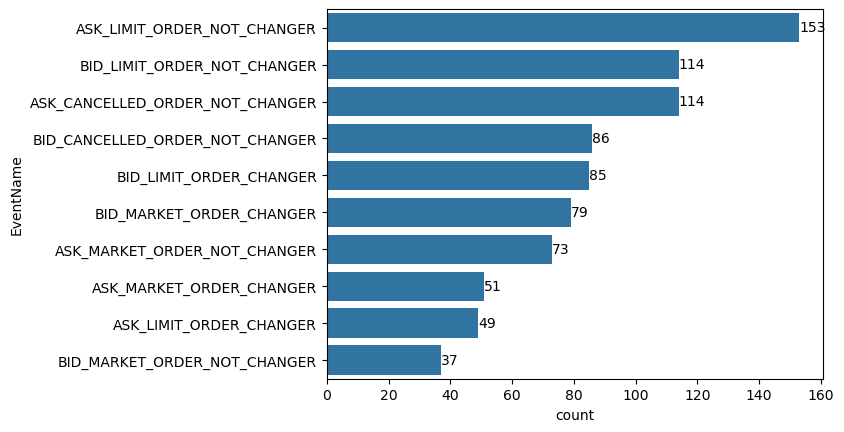

In [49]:
sns.barplot(data=event_type_counts_df, y='EventName', x='count')
# add number of events as text on the bars
for i, v in enumerate(msg_df_for_events_at_max_level['EventName'].value_counts()):
    plt.text(v, i, str(v), color='black', va='center')

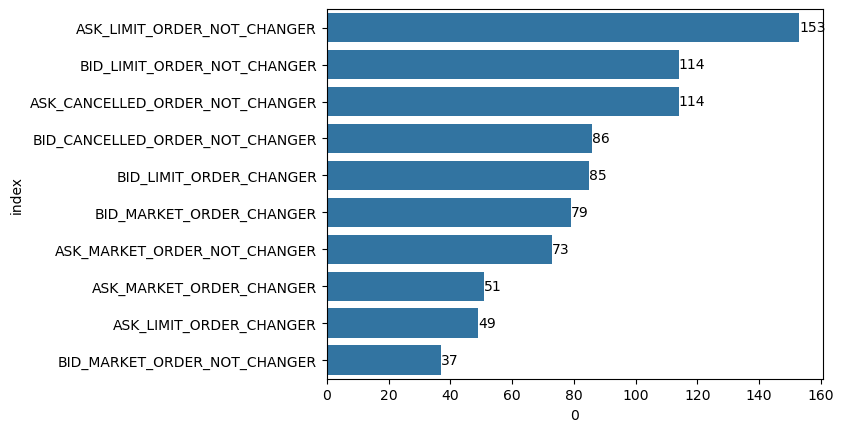

In [42]:
my_events_df = pd.DataFrame([{k.name:len(v) for k,v in event_type_times_map.items()}]).T.reset_index().sort_values(by=0, ascending=False)
sns.barplot(data=my_events_df, y='index', x=0)
# add number of events as text on the bars
for i, v in enumerate(my_events_df[0]):
    plt.text(v, i, str(v), color='black', va='center')

In [43]:
event_type_times_map[LOBEventType.BID_LIMIT_ORDER_CHANGER]

array([124, 127, 155, 233, 235, 266, 325, 332, 335, 339, 344, 345, 425,
       432, 443, 444, 448, 451, 454, 457, 459, 460, 465, 468, 470, 478,
       485, 487, 494, 497, 518, 525, 544, 548, 552, 556, 559, 564, 568,
       572, 578, 582, 586, 592, 596, 600, 606, 610, 614, 620, 624, 628,
       634, 638, 642, 648, 652, 656, 662, 666, 670, 676, 680, 684, 690,
       694, 698, 704, 708, 743, 752, 758, 797, 799, 802, 839, 855, 865,
       944, 969, 970, 973, 980, 989, 992])

In [44]:
msg_df_for_events_at_max_level[
    msg_df_for_events_at_max_level['EventName'] == 'BID_LIMIT_ORDER_CHANGER'
]['Time'].isin(event_type_times_map[LOBEventType.BID_LIMIT_ORDER_CHANGER])

1      False
124     True
127     True
155     True
233     True
       ...  
970     True
973     True
980     True
989     True
992     True
Name: Time, Length: 86, dtype: bool

In [45]:
msg_df_for_events_at_max_level[msg_df_for_events_at_max_level['Time'] == 84]

,Time,Type,Size,Price,Direction,Changed,Changer,ChangerSize,EventName
84,84,CANCELLED,286,2236200,BID,"[BidPrice3, BidSize3, BidPrice4, BidSize4, Bid...",False,False,BID_CANCELLED_ORDER_NOT_CHANGER


In [46]:
reduced_lob_df[reduced_lob_df['Timestamp'] == 84]

,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10,Timestamp
84,2240000,417,2237500,74,2242400,20,2236500,2,2242500,100,...,10,2267700,100,2226200,100,2294300,100,2213000,4000,84.0
